In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450,
               800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]], dtype = np.float64)

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype = np.float64)

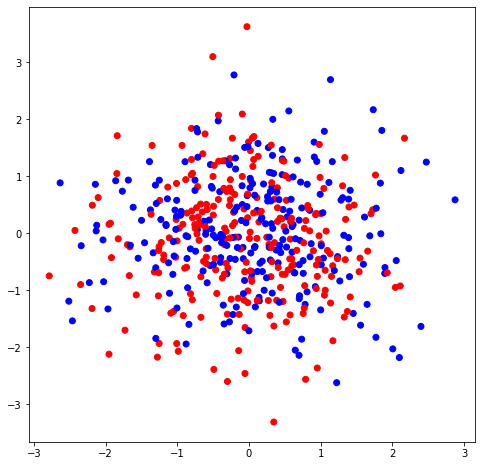

In [3]:
from sklearn import datasets
from matplotlib.colors import ListedColormap
classes = datasets.make_classification(n_samples=500, n_features=100
                                       , n_informative=20,
                                       n_redundant=0, n_classes=2, random_state=5)
colors = ListedColormap(['red', 'blue'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)

np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]

X_train_tr = X_train.transpose()
y_train_tr = y_train
X_test_tr = X_test.transpose()
y_test_tr = y_test

In [4]:
class Classifier:
    def __init__(self):
        self.Errors_train = list()
        self.Errors_test = list()

    """
    метрики
    """
    @staticmethod
    def confusion_matrix(y_pred, y_test): # функция составления матрицы ошибок
        TP = TN = FP = FN = 0
        for y_p, y_t in zip(y_pred, y_test):
            if y_p == 1:
                if y_t == 1:
                    TP += 1
                else:
                    TN += 1
            else:
                if y_t == 0:
                    FP += 1
                else:
                    FN += 1
        return np.array([[TP, TN], [FP, FN]])
    
    @staticmethod
    def Accuracy(matrix):
        TP, TN = matrix[0]
        FP, FN = matrix[1]
        return (TP + TN) / (TP + TN + FP + FN)
    
    @staticmethod
    def Precision(matrix):
        TP, TN = matrix[0]
        FP, FN = matrix[1]
        return TP / (TP + FP)
    
    @staticmethod
    def Recall(matrix):
        TP, TN = matrix[0]
        FP, FN = matrix[1]
        return TP / (TP + FN)
    
    @staticmethod
    def F1_score(precision, recall):
        return (2 * precision * recall)/ (precision + recall)
    
    
    @staticmethod
    def calc_logloss(y, y_pred, s=1e-15):
        """
        Функция ошибок
        """
        y_pred[y_pred == 1] -= s  # Задание 1
        y_pred[y_pred == 0] += s  # Задание 1
        """
        Для того чтобы под логарифм не попадали нули,
        придумал уменьшить диапазон значений предсказанных вероятностей с [0; 1] до [0+s; 1-s].
        В данной ситуации взял очень малое s чтобы существенно не влиять на вычисления.
        """
        err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
        return err
    
    @staticmethod
    def sigmoid(z):
        res = 1 / (1 + np.exp(-z))
        return res
    
    def predict(self, X):
        self.pred_proba = self.sigmoid(np.dot(self.W, X)) # 3 задание
        
        # 4 задание
        self.y_pred = self.pred_proba.copy()
        self.y_pred[self.y_pred >= 0.5] = 1  
        self.y_pred[self.y_pred < 0.5] = 0
        
        
    def calc_pred_proba(self, X): 
        return self.sigmoid(np.dot(self.W, X))

    def fit(self, X_train, y_train, X_test, y_test, iterations, l2=None, alpha=1e-4):
        np.random.seed(42)
        self.W = np.random.randn(X_train.shape[0])
        n = X_train.shape[1]
        errs = list()
        for i in range(1, iterations+1):
            z = np.dot(self.W, X_train)
            y_pred = self.sigmoid(z)
            err_train = self.calc_logloss(y_train, y_pred)
            self.Errors_train.append(err_train)
            
            tmp_y_pred = self.sigmoid(np.dot(self.W, X_test))
            err_test = self.calc_logloss(y_test, tmp_y_pred)
            self.Errors_test.append(err_test)
            if l2 is None:
                self.W -= alpha * (1/n * np.dot((y_pred - y_train), X_train.T))
            else:
                self.W -= alpha * (1/n * np.dot((y_pred - y_train), X_train.T)) + self.W * l2
        
        plt.plot(range(len(self.Errors_train)), self.Errors_train, label=f'Ошибка на трейне')
        plt.plot(range(len(self.Errors_test)), self.Errors_test, label=f'Ошибка на тесте')
        plt.title(f'logloss, {iterations} итераций')
        plt.xlabel('Iteration number')
        plt.ylabel('logloss')
        plt.legend()

In [5]:
model = Classifier()

In [6]:
iterations = 100000  # 2 задание
alpha = 1e-3

In [ ]:
model.fit(X_train_tr, y_train_tr, X_test_tr, y_test_tr, iterations=iterations, alpha=alpha)

In [ ]:
model.predict(X_test_tr)
y_pred = model.y_pred
pred_proba = model.pred_proba

In [ ]:
matrix_errs = model.confusion_matrix(y_pred, y_test_tr)
accuracy = model.Accuracy(matrix_errs)
precision = model.Precision(matrix_errs)
recall = model.Recall(matrix_errs)
F1 = model.F1_score(precision, recall)
B = float(sum(y_train_tr) / y_train_tr.shape) # доля классов с меткой 1 в обучемой выборке

print(f'доля классов с меткой 1 в обучемой выборке  {B}\n')
print(f'Матрица ошибок\n{matrix_errs}\n')
print(f'accuracy = {accuracy}\n')
print(f'precision = {precision}\n')
print(f'recall = {recall}\n')
print(f'F1 = {F1}\n')


In [ ]:
Error_train1 = model.Errors_train[-1]
Error_test1 =  model.Errors_test[-1]
print(f'ошибка на трейне {Error_train1}')
print(f'ошибка на тесте {Error_test1}')

Видим что модель переобучена, попробуем обучить снова с l2 регуляризацией

In [ ]:
model2 = Classifier()
iterations = 100000
alpha = 1e-3
model2.fit(X_train_tr, y_train_tr, X_test_tr, y_test_tr, l2=1e-4 ,iterations=iterations, alpha=alpha)

In [ ]:
model2.predict(X_test_tr)
y_pred = model2.y_pred
matrix_errs = model2.confusion_matrix(y_pred, y_test_tr)
accuracy = model2.Accuracy(matrix_errs)
precision = model2.Precision(matrix_errs)
recall = model2.Recall(matrix_errs)
F1 = model2.F1_score(precision, recall)
B = float(sum(y_train_tr) / y_train_tr.shape) # доля классов с меткой 1 в обучемой выборке

print(f'Матрица ошибок\n{matrix_errs}\n')
print(f'accuracy = {accuracy}\n')
print(f'precision = {precision}\n')
print(f'recall = {recall}\n')
print(f'F1 = {F1}\n')

In [ ]:
Error_train2 = model2.Errors_train[-1]
Error_test2 =  model2.Errors_test[-1]
print(f'ошибка на трейне {Error_train2}')
print(f'ошибка на тесте {Error_test2}')

после обучения с l2 регуляризацией мы видим снижение эффекта переобучения - ошибка на тесте и на трейне ближе друг к другу чем без l2 регуляризации